# Thuật toán SVM


## 1. Những thay đổi so với SVM trước đó:
- SVM cũ: dùng kernel tuyến tính và tối ưu bằng Gradient Descent
- SVM mới: dùng kernel rbf và tối ưu bằng SMO

In [1]:
import numpy as np
import glob2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from random import randrange
import logging
import random
import numba as nb
from numba import cuda
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2. Kernel RBF:

- Là kernel dùng để biểu diễn quan hệ phi tuyến trong dữ liệu.
- Công thức kernel trick: $\exp(-\gamma*||x-x'||^2)$ với $0<\gamma<1$

In [2]:
def rbf(self, x1, x2):
    return np.exp(-self.gamma * (np.linalg.norm(x1 - x2) **2 ))

## 3. SVM:
- Output của thuật toán: $u_i = \sum^n_{j=1}(y_j\alpha_jK(x_j,x_i))-b$
- Dự đoán: $y\_pred = sign(u_i)$
- $K(x_j, x_i)$: rbf kernel của $x_j$ và $x_i$
- $\alpha_j$: Lagrange multiplier của data point thứ j
- $y_j$: true label (1 hoặc -1) thứ j

## 4. SMO:
- Ý tưởng: chuyển bài toán ban đầu thành các bài toán tối ưu 2 Lagrange multipliers. Tối ưu cho đến khi tất cả data point đều thỏa điều kiện KKT
- Gồm 2 phần chính:
  + Heuristic chọn ra 2 multipliers để tối ưu
  + Tối ưu 2 multipliers vừa chọn
- Điều kiện KKT: 1 điểm gọi là vi phạm điều kiện nếu $( E_i * y_i < - tol\ \&\  alpha_i < C)\ or\ (E_i*y_i > tol\ and\ alpha_i > 0)$ và ngược lại.
- Với $E_i=u_i-y_i$ là độ lỗi hiện tại của data point thứ i

### 4.1: Heuristic:
- Heuristic 1: dùng để chọn ra alpha1 để tối ưu, luân phiên thực hiện 2 bước sau đến khi tất cả datapoint thỏa KKT:
  + Duyệt toàn bộ data, tối ưu tất cả những điểm không thỏa KKT.
  + Duyệt các data point non-bound, tối ưu tất cả những điểm không thỏa KKT.
- Heuristic 2: Sau khi chọn được alpha1 bất kỳ từ H1 thì tiến hành chọn alpha2:
  + Duyệt toàn bộ non-bound data point, tìm điểm có độ lỗi cách xa nhất với độ lỗi của alpha1. Nếu không có thì
  + Duyệt toàn bộ non-bound data point, bắt đầu từ điểm ngẫu nhiên và tiến hành tối ưu thử đến khi được tối ưu. Nếu không được thì:
  + Thực hiện tương tự nhưng duyệt với toàn bộ data.
- non-bound: Mỗi alpha sẽ có 2 biên là 0 và C. Data point i được gọi là non-bound nếu $0<alpha_i<C$ và ngược lại.

```python
def choose_a1():
  examine_all = True
  num_changed = 0
  while num_changed > 0 or examine_all:
    num_changed = 0
    if examine_all:
      for i in range(n_samples):
        num_changed += choose_a2(i, X, y)
    else:
      for i in range(n_samples):
        if 0 < alphas[i] < self.C:
          num_changed += choose_a2(i, X, y)
    if examine_all:
      examine_all = False
    elif num_changed == 0:
      examine_all = True
```

```python
def choose_a2():
  # Check KKT
  if (y1 * E1 < -tol and alpha1 < C) or (y1*E1 > tol and alpha1 > 0):
    i2 = find_max_error_differences()
    if optimize(i1, i2):
      return 1
    for i2 in non_bound_data:
      if optimize(i1, i2):
        return 1
    for i2 in all_data:
      if optimize(i1, i2):
        return 1
  return 0
```

### 4.2: Tối ưu hóa alpha1 và alpha2

- Tối ưu hóa để alpha1 và alpha2. Nếu tối ưu hóa thành công thì return True và ngược lại.
- Chi tiết các bước tối ưu hóa và công thức xem tại: ... 

## 4.3: Class SVM implement:

In [3]:
class SVM:
  def __init__(self, C=1.0, gamma=-1, tol=1e-3, eps = 1e-5, max_iter=1200):
    self.C = C
    self.gamma = gamma
    self.tol = tol
    self.max_iter = max_iter
    self.n_iter = 0
    self.eps = eps

  def rbf(self, x1, x2):
    return np.exp(-self.gamma * (np.linalg.norm(x1 - x2) **2 ))
  
  def output(self, x, X, y, n_samples):
    return np.sum([self.alphas[i] * y[i] * self.rbf(X[i], x) for i in range(n_samples)]) - self.b

  def get_error(self, i, X, y):   
    if self.non_bound[i]:
      return self.errors[i]
    else:
      op = self.output(X[i], X, y, self.n_samples) - y[i]
      self.errors[i] = op
      return op  

  def predict(self, X):
    pred = []
    for x in X:
      pred.append(np.sign(self.output(x, self.support_vectors, self.support_vector_labels, self.n_vector)))
    return pred
    
  def compute_L_H(self):
    if self.y1 != self.y2:
      L = max(0, self.alpha2 - self.alpha1)
      H = min(self.C, self.C + self.alpha2 - self.alpha1)
    else:
      L = max(0, self.alpha2 + self.alpha1 - self.C)
      H = min(self.C, self.alpha2 + self.alpha1)
    return L, H
  
  def compute_threshold(self, alpha1_new, alpha2_new, k11, k12, k22):
    b1 = self.E1 + self.y1 * (alpha1_new - self.alpha1) * k11 + \
        self.y2 * (alpha2_new - self.alpha2) * k12 + self.b
    b2 = self.E2 + self.y1 * (alpha1_new - self.alpha1) * k12 + \
        self.y2 * (alpha2_new - self.alpha2) * k22 + self.b

    if 0 < alpha1_new and alpha1_new < self.C:
      return b1
    if 0 < alpha2_new and alpha2_new < self.C:
      return b2
    return (b1 + b2)/2.0
    
  def update_error_cache(self, alpha1_new, alpha2_new, old_b, X):
    delta1 = self.y1 * (alpha1_new - self.alpha1)
    delta2 = self.y2 * (alpha2_new - self.alpha2)
    for i in self.non_bound_idx:
      self.errors[i] += delta1 * self.rbf(self.x1, X[i]) + \
                        delta2 * self.rbf(self.x2, X[i]) + \
                        old_b - self.b

  def update_non_bound(self, i1, i2):
    if 0 < self.alphas[i1] and self.alphas[i1] < self.C:
      self.non_bound[i1] = True
      if i1 not in self.non_bound_idx:
        self.non_bound_idx.append(i1)
    else:
      self.non_bound[i1] = False
      if i1 in self.non_bound_idx:
        self.non_bound_idx.remove(i1)
      
    if 0 < self.alphas[i2] and self.alphas[i2] < self.C:
      self.non_bound[i2] = True
      if i2 not in self.non_bound_idx:
        self.non_bound_idx.append(i2)
    else:
      self.non_bound[i2] = False
      if i2 in self.non_bound_idx:
        self.non_bound_idx.remove(i2)

    
  def get_alpha2(self, L, H, k11, k12, k22, s):
    eta = k11 + k22 - 2 * k12
    if eta > 0:
      alpha2_new = self.alpha2 + self.y2 * (self.E1-self.E2)/eta
      alpha2_new = min(H, max(L, alpha2_new))
    else:
      f1 = self.y1*(self.E1 + self.b) - self.alpha1*k11 - s*self.alpha2*k12
      f2 = self.y2*(self.E2 + self.b) - s*self.alpha1*k12 - self.alpha2*k22
      L1 = self.alpha1 + s*(self.alpha2-L)
      H1 = self.alpha1 + s*(self.alpha2-H)
      Lobj = L1*f1 + L*f2 + 0.5*(L1**2)*k11 + 0.5*(L**2)*k22 + s*L*L1*k12
      Hobj = H1*f1 + H*f2 + 0.5*(H1**2)*k11 + 0.5*(H**2)*k22 + s*H*H1*k12
      if Lobj < Hobj - self.eps:
        alpha2_new = L
      elif Lobj > Hobj + self.eps:
        alpha2_new = H
      else:
        alpha2_new = self.alpha2
    return alpha2_new
    
  def take_step(self, i1, i2, X, y):
    if i1 == i2:
      return 0
    self.y2 = y[i2]
    self.alpha2 = self.alphas[i2]
    self.x2 = X[i2]
    self.E2 = self.get_error(i2, X, y)
    s = self.y1 * self.y2
    L, H = self.compute_L_H()
    if L==H:
      return 0
    k11 = self.rbf(self.x1, self.x1)
    k12 = self.rbf(self.x1, self.x2)
    k22 = self.rbf(self.x2, self.x2)
    self.alphas[i2] = self.get_alpha2(L, H, k11, k12, k22, s)
    if abs(self.alphas[i2] -self.alpha2) < self.eps * (self.alphas[i2] + self.alpha2 + self.eps):
      return 0
    self.alphas[i1] = self.alpha1 + s * (self.alpha2 - self.alphas[i2])
    old_b = self.b
    self.b = self.compute_threshold(self.alphas[i1], self.alphas[i2], k11, k12, k22)
    self.update_non_bound(i1, i2)
    self.update_error_cache(self.alphas[i1], self.alphas[i2], old_b, X)
    return 1
  
  def second_choice_heuristic(self, X ,y):
    i2 = -1
    m = 0.0
    for i in self.non_bound_idx:
      step = abs(self.get_error(i, X, y) - self.E1)
      if step > m:
        m = step
        i2 = i
    return i2
  

  def examine_example(self, i1, X, y):
    self.y1 = y[i1]
    self.alpha1 = self.alphas[i1]
    self.x1 = X[i1]
    self.E1 = self.get_error(i1, X, y)
    
    r2 = self.E1 * self.y1
    if (r2 < -self.tol and self.alpha1 < self.C) or \
      (r2 > self.tol and self.alpha1 > 0):
      n_non_bound = len(self.non_bound_idx)
      mark = -1
      if (n_non_bound > 1):
        i2 = self.second_choice_heuristic(X, y)
        if i2 != -1:
          if self.take_step(i1, i2, X, y):
            return 1
        mark = i2
      if n_non_bound > 0:
        rand_i = randrange(n_non_bound)
        for i2 in self.non_bound_idx[rand_i:] + self.non_bound_idx[:rand_i]:
          if i2 == mark:
            continue
          if self.take_step(i1, i2, X, y):
            return 1
          
      rand_i = randrange(self.n_samples)
      all_indexes = list(range(self.n_samples))
      for i2 in all_indexes[rand_i:] + all_indexes[:rand_i]:
        if self.non_bound[i2]:
          continue
        if self.take_step(i1, i2, X, y):
          return 1
    return 0

  def fit(self, X, y):
    # random.seed(42)
    self.n_samples, self.n_features = X.shape
    if self.gamma < 0 or self.gamma > 1:
      self.gamma = 1/(self.n_features * X.var())
    self.errors = np.zeros(self.n_samples)
    self.alphas = np.zeros(self.n_samples)
    self.non_bound = np.array([False for _ in range(self.n_samples)])
    self.non_bound_idx = []
    self.b = 0
    num_changed = 0
    examine_all = True
    while num_changed > 0 or examine_all:
      self.n_iter += 1
      num_changed = 0
      if examine_all:
        for i in range(self.n_samples):
          num_changed += self.examine_example(i, X, y)
      else:
        for i in range(self.n_samples):
          if 0 < self.alphas[i] < self.C:
            num_changed += self.examine_example(i, X, y)
  
      if examine_all:
        examine_all = False
      elif num_changed == 0:
        examine_all = True
        
    sv_idx = (self.alphas > 0)
    self.support_vectors = X[sv_idx]
    self.support_vector_labels = y[sv_idx]
    self.n_vector = np.sum(sv_idx)

## 4.4: So sánh với SVM cũ:

### 4.4.1: Class SVM cũ:

In [4]:
class SVM_old():
  def __init__(self,C=1.0):
    # C error terms
    self.C = C
    self.w = 0
    self.b = 0

  # Hinge Loss Function / Calculation
  def hingeloss(self, w, b, x, y):
    # Regularizer term
    reg = 0.5 * (w * w)
    for i in range(x.shape[0]):
      # Optimization term
      opt_term = y[i] * ((np.dot(w, x[i])) + b)
      # calculating loss
      loss = reg + self.C * max(0, 1-opt_term)
    return loss[0][0]

  def fit(self, X, Y, batch_size=100, learning_rate=0.001, epochs=1000):
    # The number of features in X
    number_of_features = X.shape[1]
    # The number of Samples in X
    number_of_samples = X.shape[0]
    c = self.C
    # Creating ids from 0 to number_of_samples - 1
    ids = np.arange(number_of_samples)
    # Shuffling the samples randomly
    np.random.shuffle(ids)
    # creating an array of zeros
    w = np.zeros((1, number_of_features))
    b = 0
    losses = []
    # Gradient Descent logic
    for i in range(epochs):
      # Calculating the Hinge Loss
      l = self.hingeloss(w, b, X, Y)
      # Appending all losses 
      losses.append(l)
      # Starting from 0 to the number of samples with batch_size as interval
      for batch_initial in range(0, number_of_samples, batch_size):
        gradw = 0
        gradb = 0
        for j in range(batch_initial, batch_initial + batch_size):
          if j < number_of_samples:
            x = ids[j]
            ti = Y[x] * (np.dot(w, X[x].T) + b)
            if ti > 1:
              gradw += 0
              gradb += 0
            else:
              # Calculating the gradients
              #w.r.t w 
              gradw += c * Y[x] * X[x]
              # w.r.t b
              gradb += c * Y[x]
        # Updating weights and bias
        w = w - learning_rate * w + learning_rate * gradw
        b = b + learning_rate * gradb
    self.w = w
    self.b = b
    return self.w, self.b, losses
      
  def predict(self, X):
    prediction = np.dot(X, self.w[0]) + self.b # w.x + b
    return np.sign(prediction)

### 4.4.2: Đọc data:

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
link_cat = r'C:\Users\dolek\Documents\GitHub\Applied-Parallel-Programming\Main\Data\Cat\**'
link_dog = r'C:\Users\dolek\Documents\GitHub\Applied-Parallel-Programming\Main\Data\Dog\**'
list_cat = glob2.glob(link_cat)
list_dog = glob2.glob(link_dog)

In [7]:
test_cases = [150, 200]

In [ ]:
acc_1 = []
acc_2 = []
time_1 = []
time_2 = []
for t in test_cases:
  n_samples = int(t/2)
  cat_images = []
  cat_labels = []
  for i in range(n_samples):
    if('jpg' in list_cat[i]):
        img = Image.open(list_cat[i]).convert('RGB')
        img = img.resize((400,400), Image.LANCZOS)
        if len(np.array(img).shape)  == 3:
            cat_images.append(np.array(img))
            cat_labels.append(1)
  dog_images = []
  dog_labels = []
  for i in range(n_samples):
    if('jpg' in list_dog[i]):
        img = Image.open(list_dog[i]).convert('RGB')
        img = img.resize((400,400), Image.LANCZOS)
        if len(np.array(img).shape)  == 3:
            dog_images.append(np.array(img))
            dog_labels.append(-1)
  for index in range(len(cat_images)):
    if cat_images[index].shape[2] != 3:
        print(index, cat_images[index].shape[2])
  for index in range(len(dog_images)):
    if dog_images[index].shape[2] != 3:
        print(index, dog_images[index].shape[2])  
  cat_images = np.array(cat_images)
  cat_labels = np.array(cat_labels)
  dog_images = np.array(dog_images)
  dog_labels = np.array(dog_labels)


  x_cat_train, x_cat_test, y_cat_train, y_cat_test = train_test_split(cat_images, cat_labels, test_size=0.3)
  x_dog_train, x_dog_test, y_dog_train, y_dog_test = train_test_split(dog_images, dog_labels, test_size=0.3)
  X_train = np.concatenate((x_cat_train, x_dog_train), axis = 0)
  y_train = np.concatenate((y_cat_train, y_dog_train), axis = 0)
  X_test = np.concatenate((x_cat_test, x_dog_test), axis = 0)
  y_test = np.concatenate((y_cat_test, y_dog_test), axis = 0)

  shuffler = np.arange(X_train.shape[0])
  np.random.shuffle(shuffler)
  X_train = X_train.take(shuffler)
  y_train = y_train.take(shuffler)
  shuffler = np.arange(X_test.shape[0])
  np.random.shuffle(shuffler)
  X_test = X_test.take(shuffler)
  y_test = y_test.take(shuffler)

  x_train = np.array([x.flatten() for x in X_train])
  x_test = np.array([x.flatten() for x in X_test])
  start = time.time()
  svm = SVM()
  svm.fit(x_train, y_train)
  pred = svm.predict(x_test)
  end = time.time()
  time_1.append(end-start)
  acc_1.append(accuracy_score(pred, y_test))
  start = time.time()
  svm = SVM_old()
  svm.fit(x_train, y_train)
  pred = svm.predict(x_test)
  end = time.time()
  time_2.append(end-start)
  acc_2.append(accuracy_score(pred, y_test))

In [ ]:
plt.plot(test_cases, acc_1, label = 'New SVM')
plt.plot(test_cases, acc_2, label = 'Old SVM')
plt.title("Accuracy comparison")
plt.legend()
plt.show()

In [ ]:
plt.plot(test_cases, time_1, label = 'New SVM')
plt.plot(test_cases, time_2, label = 'Old SVM')
plt.title("Time comparison")
plt.legend()
plt.show()

### 4.3: So sánh khi kết hợp với HOG:

#### Hog model

In [ ]:
from numba import cuda,float64

import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image
import cv2
import math
import operator

class HOG:
    def __init__(self, blockSize, cellSize, nbins, sbins, threadsperblock):
        self.blockSize       = blockSize
        self.cellSize        = cellSize
        self.nbins           = nbins
        self.sbins           = sbins
        self.threadsperblock = threadsperblock
        self.x_Dim   = self.threadsperblock[0]//self.cellSize[0]
        self.y_Dim   = self.threadsperblock[1]//self.cellSize[1]
    
    @staticmethod
    @cuda.jit
    def __gray_kernel(input, width, height, channel, gray):
        row, col = cuda.grid(2)
        if row >= height or col >= width or channel != 3:
            return
        rgb = input[row][col]
        gray[row][col] = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
    
    def __gray(self):
        picture = self.picture_array
        # Memory Allocation
        blockspergrid_x = math.ceil(self.picture_array.shape[0] / self.threadsperblock[0])
        blockspergrid_y = math.ceil(self.picture_array.shape[1] / self.threadsperblock[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        gray_dev   = np.empty([self.height, self.width],dtype = float)
        input_dev   = cuda.to_device(self.picture_array)
        gray_device = cuda.device_array_like(gray_dev)
        kernel = self.__gray_kernel
        kernel[blockspergrid, self.threadsperblock](input_dev, self.width, self.height, self.channel, gray_device)
        self.gray = gray_device
    
    @staticmethod
    @cuda.jit
    def __calc_gradient_kernel_2(input, width, height, magnitude, direction):
        row, col = cuda.grid(2)
        y = 0.0
        x = 0.0
        if (row>=height) or (col>=width):
            return
        for i in range(-1,2):
            pixel_r = row + i
            pixel_r = min(max(0, pixel_r), height - 1)
            y += input[pixel_r,col] * i

            pixel_c = col + i
            pixel_c = min(max(0, pixel_c), width - 1)
            x += input[row,pixel_c] * i

        magnitude[row, col] = math.sqrt(y**2+x**2)
        direction[row, col] = operator.mod((360 + math.atan2(y,x)*180/math.pi), 360)
        
    def __calc_gradient(self):
        blockspergrid_x = math.ceil(self.picture_array.shape[0] / self.threadsperblock[0])
        blockspergrid_y = math.ceil(self.picture_array.shape[1] / self.threadsperblock[1])
        blockspergrid   = (blockspergrid_x, blockspergrid_y)

        mag_dev            = np.zeros((self.height, self.width))
        dir_dev            = np.zeros((self.height, self.width))


        mag_device            = cuda.to_device(mag_dev)
        dir_device            = cuda.to_device(dir_dev)
        
        self.__calc_gradient_kernel_2[blockspergrid, self.threadsperblock]\
                (self.gray, self.width, self.height,mag_device, dir_device)

        return mag_device,dir_device
    
    def __calc_direc_mag(self):
        self.__gray()
        mag_device, dir_device = self.__calc_gradient()
        self.magnitude = mag_device
        self.direction = dir_device
    

    @staticmethod
    @cuda.jit()
    def __hist_kernel(direction, magnitude, cell_size, d_sbin, result_out,out_l2,x_Dim,y_Dim,nbins):    
        cur_r, cur_c  = cuda.grid(2)
        height, width = direction.shape

        idy   = int(cur_r//cell_size[0])
        idx   = int(cur_c//cell_size[1])
        sbin  = d_sbin

        # Creat 3D shared array
        shared     = cuda.shared.array(shape=(4, 4, 9), dtype=float64)
        l2         = cuda.shared.array(shape=(4, 4)   , dtype=float64)
        idy_shared = idy%x_Dim
        idx_shared = idx%y_Dim

        condition_1 = cur_r%cell_size[0]
        condition_2 = int(cur_c  %(cell_size[1]))
        if  condition_1 == 0:
            check   = condition_2 
            if check < 8:
                shared[idy_shared][idx_shared][check] = 0.0
        elif  condition_1 == 1:
            check   = condition_2 
            if check == 0:
                shared[idy_shared][idx_shared][8] = 0.0
                l2[idy_shared][idx_shared] = 0.0

        cuda.syncthreads()
        # kiểm tra
        if cur_r>=height or cur_c>= width:
            return
        thread_direction = direction[cur_r][cur_c]
        thread_mag       = magnitude[cur_r][cur_c]
        # chia lấy phần nguyên và phần dư
        quotient  = int(thread_direction//sbin)
        remainder =     thread_direction % sbin

        if remainder==0:
            cuda.atomic.add(shared, (idy_shared, idx_shared, quotient), thread_mag)

        else:
            first_bin = quotient
            second_bin     = first_bin+1
            need_to_add    = thread_mag*((second_bin*sbin - thread_direction)/sbin)
            cuda.atomic.add(shared, (idy_shared, idx_shared, first_bin), need_to_add)


            second_bin_idx = second_bin
            if second_bin > 8:
                second_bin_idx = 0
            need_to_add_2  = thread_mag*((thread_direction - first_bin*sbin)/sbin)   

            cuda.atomic.add(shared, (idy_shared, idx_shared, second_bin_idx), need_to_add_2)

        cuda.syncthreads()

        if condition_1 == 0:
            check   = condition_2
            if check < 8:
                result_out[idy][idx][check]     = shared[idy_shared][idx_shared][check]
                cuda.atomic.add(l2, (idy_shared, idx_shared), shared[idy_shared][idx_shared][check]**2)
        elif  condition_1 == 1:
            if check == 0:
                cuda.atomic.add(l2, (idy_shared, idx_shared), shared[idy_shared][idx_shared][8]**2)
                result_out[idy][idx][8]            = shared[idy_shared][idx_shared][8]
                cuda.syncthreads()
                out_l2[idy][idx]                   = l2[idy_shared][idx_shared]
        else:
            return


    
    def __all_hist(self):
        blockspergrid_x = math.ceil(self.direction.shape[0] / self.threadsperblock[0])
        blockspergrid_y = math.ceil(self.direction.shape[1] / self.threadsperblock[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        
        hist_dev           = np.empty([self.n_cell[0], self.n_cell[1], self.nbins],dtype = np.float64)
        l2_dev             = np.empty([self.n_cell[0], self.n_cell[1]],dtype = np.float64)
        d_cell_size        = cuda.to_device(self.cellSize)
        hist_device        = cuda.device_array_like(hist_dev)
        l2_device          = cuda.device_array_like(l2_dev)
        kernel = self.__hist_kernel
        kernel[blockspergrid, self.threadsperblock]\
                            (self.direction, self.magnitude,d_cell_size, self.sbins, hist_device,l2_device,\
                                     self.x_Dim,self.y_Dim,self.nbins)
        self.hist        = hist_device
        self.test        = hist_device.copy_to_host()
        self.l2_sum      = l2_device
    @staticmethod
    @cuda.jit()
    def __l2_kernel(l2_hist,n_block,final_l2):
        row, col  = cuda.grid(2)
        if row >= n_block[0] or col >= n_block[1]:
            return
        need_to_sum = l2_hist[row:row+2, col:col+2]
        sum_result = 0.0
        for i in range(2):
            for j in range(2):
                sum_result += need_to_sum[i][j] 
        final_l2[row][col] = math.sqrt(sum_result)
    
    @staticmethod
    @cuda.jit()
    def __normalize_kernel(hist, n_block, block_size, l2, normed):
        row, col  = cuda.grid(2)
        if row >= n_block[0] or col >= n_block[1]:
            return
        for y in range(block_size[0]):
            for x in range(block_size[1]):
                for i in range(9):
                    normed[row][col][y][x][i] = hist[row + y][col + x][i]/(l2[row][col]+1)
        
    def compute_HOG(self, picture):
        
        self.picture_array = picture
        self.height, self.width, self.channel = self.picture_array.shape
        self.n_cell  = (self.height//self.cellSize[0], self.width//self.cellSize[1])
        self.n_block = (self.n_cell[0] - self.blockSize[0] + 1, self.n_cell[1] - self.blockSize[1] + 1)
        
        self.__calc_direc_mag()
        self.__all_hist()
        
        blockspergrid_x = math.ceil(self.n_block[0] /  self.threadsperblock[0])
        blockspergrid_y = math.ceil(self.n_block[1] /  self.threadsperblock[1])
        blockspergrid   = (blockspergrid_x, blockspergrid_y)
                
        norm_array_size = self.n_block[0] * self.n_block[1] * self.blockSize[0] * self.blockSize[1] * self.nbins
        final_l2   = np.empty([self.n_block[0],self.n_block[1]],dtype = np.float64)
        device_l2 = cuda.device_array_like(final_l2)
        self.__l2_kernel[blockspergrid, self.threadsperblock](self.l2_sum,self.n_block,device_l2)
        self.l2 = device_l2
        

        norm_block    = np.zeros((self.n_block[0], self.n_block[1], self.blockSize[0], self.blockSize[1], self.nbins))
        normed_device = cuda.to_device(norm_block)
            
        self.__normalize_kernel[blockspergrid, self.threadsperblock] \
                                    (self.hist, self.n_block, self.blockSize, self.l2, normed_device)
        norm_block = normed_device.copy_to_host()
        
        self.HOG        = norm_block.reshape(norm_array_size)
        self.norm_block = norm_block
        return self.HOG

In [ ]:
def big_fit(X_train, y_train, hog, svm):
  x_train = []
  t = 0
  for x in X_train:
    x_train.append(hog.compute_HOG(x))
  x_train = np.array(x_train)
  svm.fit(x_train, y_train)

def big_predict(X_test, y_test, hog, svm):
  x_test = []
  for x in X_test:
    x_test.append(hog.compute_HOG(x))
  x_test = np.array(x_test)
  return svm.predict(x_test)

In [ ]:
acc_1 = []
acc_2 = []
time_1 = []
time_2 = []
hog = HOG((2,2), (8,8), 9, 40,(32,32))
for t in test_cases:
  n_samples = int(t/2)
  images = []
  labels = []
  for i in range(n_samples):
    if('jpg' in list_cat[i]):
        img = Image.open(list_cat[i]).convert('RGB')
        img = img.resize((400,400), Image.LANCZOS)
        if len(np.array(img).shape)  == 3:
            images.append(np.array(img))
            labels.append(1)
  for i in range(n_samples):
    if('jpg' in list_dog[i]):
        img = Image.open(list_dog[i]).convert('RGB')
        img = img.resize((400,400), Image.LANCZOS)
        if len(np.array(img).shape)  == 3:
            images.append(np.array(img))
            labels.append(-1)
  X = np.array(images)
  y = np.array(labels)

  for index in range(len(images)):
    if images[index].shape[2] != 3:
        print(index, images[index].shape[2])
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
  x_train = np.array([x.flatten() for x in X_train])
  x_test = np.array([x.flatten() for x in X_test])
  start = time.time()
  svm = SVM()
  big_fit(X_train, y_train, hog, svm)
  pred = big_predict(X_test, y_test, hog, svm)
  end = time.time()
  time_1.append(end-start)
  acc_1.append(accuracy_score(pred, y_test))
  start = time.time()
  svm = SVM_old()
  big_fit(X_train, y_train, hog, svm)
  pred = big_predict(X_test, y_test, hog, svm)
  end = time.time()
  time_2.append(end-start)
  acc_2.append(accuracy_score(pred, y_test))

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


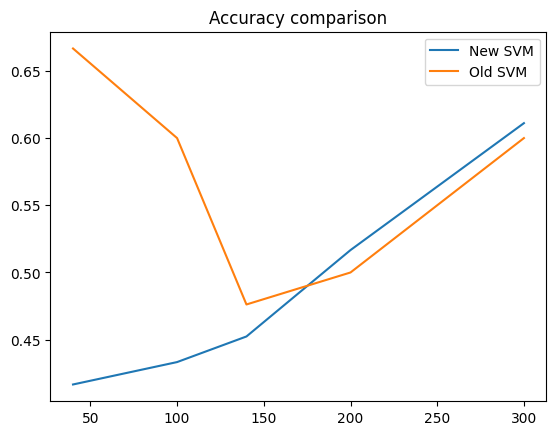

In [ ]:
plt.plot(test_cases, acc_1, label = 'New SVM')
plt.plot(test_cases, acc_2, label = 'Old SVM')
plt.title("Accuracy comparison")
plt.legend()
plt.show()

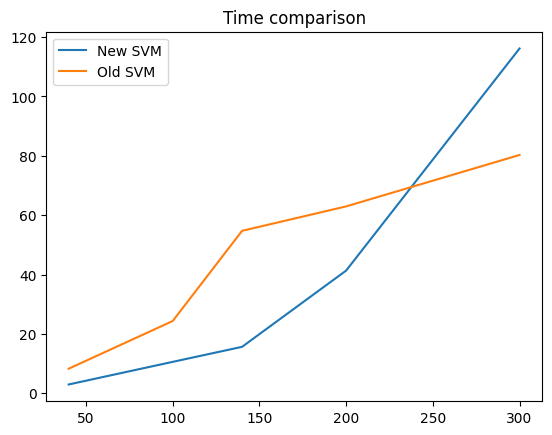

In [ ]:
plt.plot(test_cases, time_1, label = 'New SVM')
plt.plot(test_cases, time_2, label = 'Old SVM')
plt.title("Time comparison")
plt.legend()
plt.show()